In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [2]:
rawfeats = pd.read_csv('dengue_features_train.csv')
rawlabels = pd.read_csv('dengue_labels_train.csv')
rawfeats['total_cases'] = rawlabels['total_cases']
sj = rawfeats[rawfeats.city=='sj']
print(sj.shape)
sj.head()

(936, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


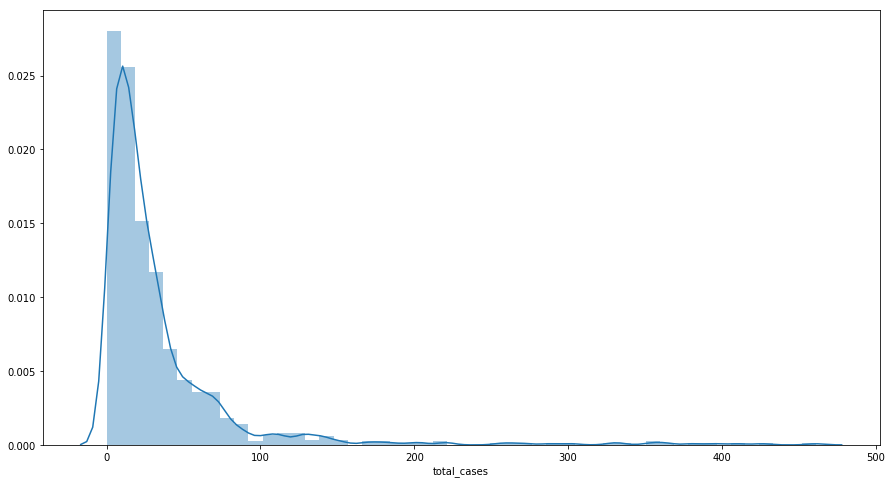

In [3]:
#outcome variable
plt.figure(figsize=[15,8])
sns.distplot(sj.total_cases, bins=50)
plt.show()

In [4]:
#Fill nas with interpolation
sj = sj.interpolate(method='linear')
#Replace week 53 with week 52
sj.loc[:,'weekofyear'] = np.where(sj.weekofyear > 52, 52, sj.weekofyear)

## No feature Engineering besides interpolated nans and a week correction

In [5]:
X = sj.drop(['week_start_date', 'total_cases', 'city', 'year', 'weekofyear'], axis=1)
y = sj.total_cases

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(655, 20)
(281, 20)


#### Linear Regression

In [7]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-30.22081001 -32.11183399 -39.0206449 ]
29.95773043242663


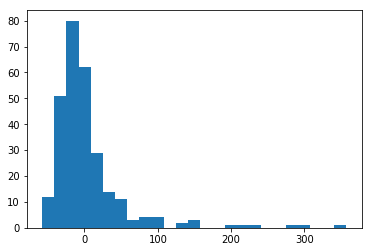

In [8]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

### Random Forest Regressor

In [9]:
rfr = RandomForestRegressor(max_depth=20, n_estimators=50, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

29.859750889679717
[-36.59968085 -33.1962766  -34.18107527]


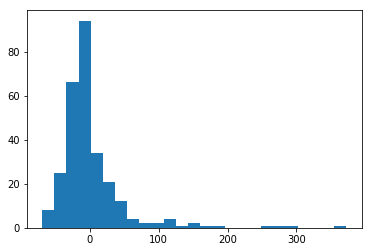

In [10]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

### KNN Regressor

In [11]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

31.945733301821953
[-34.9352115  -31.19009105 -35.28493414]


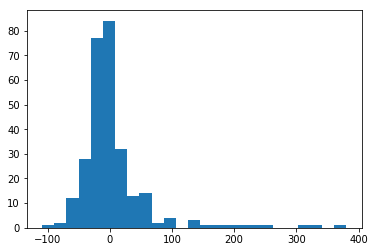

In [12]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

###  Gradient Boosting Regressor

In [13]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=3,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

27.25531499981992
[-30.89368099 -25.76394581 -26.33144175]


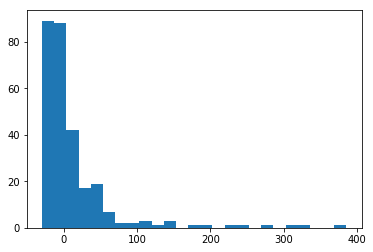

In [14]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

### Negative Binomial Regression

In [15]:
smX_train = X_train
smX_train['total_cases'] = y_train
smX_test = X_test
smX_test['total_cases'] = y_test

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [16]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw + precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + station_min_temp_c + station_precip_mm'

In [17]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [18]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

29.256227758007118

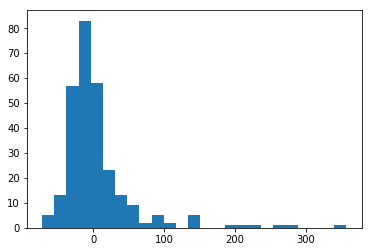

In [19]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

# Feature Engineering 

In [20]:
[x for x in sj.columns]

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

### Temperature

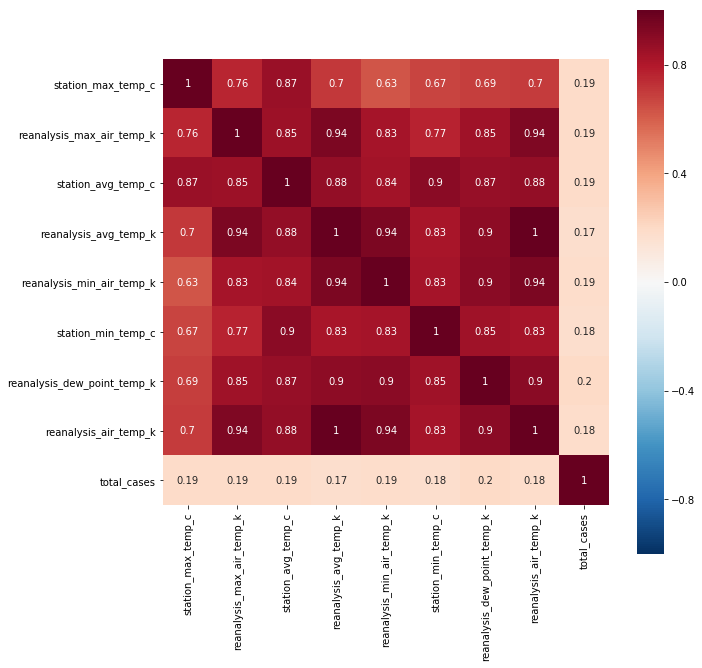

In [21]:
temps = sj[['station_max_temp_c',
            'reanalysis_max_air_temp_k',
            'station_avg_temp_c',
            'reanalysis_avg_temp_k',
            'reanalysis_min_air_temp_k',
            'station_min_temp_c',
            'reanalysis_dew_point_temp_k',
            'reanalysis_air_temp_k',
           'total_cases', ]]
plt.figure(figsize=[10,10])
sns.heatmap(temps.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=True)
plt.show()

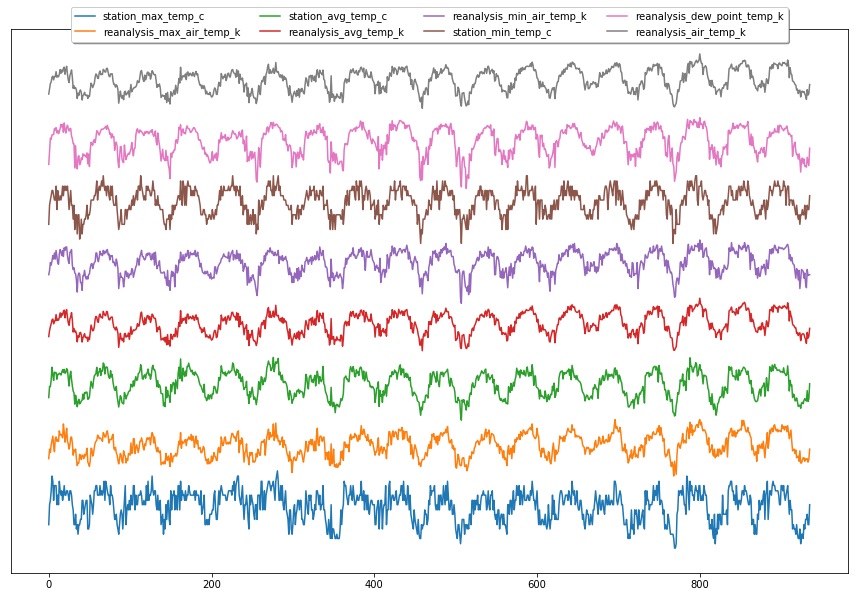

In [22]:
plt.figure(figsize=[15,10])
offset = 0
for i in temps:
    if i != 'total_cases':
        plt.plot(sj[i] - np.mean(sj[i]) + offset, label=i)
        offset+=7
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)
plt.yticks([])
plt.show()

In [23]:
temps['weekofyear'] = sj.weekofyear

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


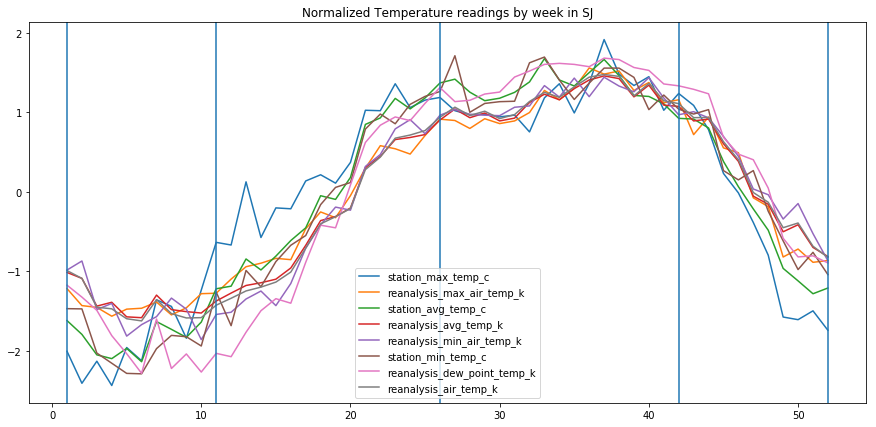

In [24]:
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings by week in SJ')
for i in temps:
    if i != 'total_cases' and i != 'weekofyear':
        plt.plot(temps.groupby('weekofyear')[i].mean() - 
                 temps[i].mean(),
            label=i)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])

plt.legend()
plt.show()

#### Conclusion: Temperature

Most of these temperature measurements are very correlated. I will keep station_max_temp_c, as that differs in a few key areas, but besides that I will simply average the rest after scaling them to be on the same range.

I will also create features to indicate the 4 seasons.

In [25]:
feats = sj[['city', 'year', 'weekofyear', 'total_cases', 'station_max_temp_c']].copy()

In [26]:
tempscols_to_average = sj.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]

scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), 
                            columns=tempscols_to_average.columns)

In [27]:
feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)

In [28]:
cutoffs = [11, 26, 42]
feats['winter'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

feats['spring'] = np.where((feats.weekofyear>=cutoffs[0]) &
                           (feats.weekofyear<cutoffs[1]), 1, 0)
feats['summer'] = np.where((feats.weekofyear>=cutoffs[1]) &
                           (feats.weekofyear<cutoffs[2]), 1, 0)
feats['fall'] = np.where((feats.weekofyear>=cutoffs[2]), 1, 0)

In [29]:
feats.groupby('weekofyear')[['winter','spring','summer','fall']].sum()
#We'll want to drop one of the boolean seasons for any models that don't
#use regularization
feats.corr()['total_cases']

year                 -0.212690
weekofyear            0.287245
total_cases           1.000000
station_max_temp_c    0.188447
temps_mean            0.197005
winter               -0.088709
spring               -0.274548
summer                0.164571
fall                  0.204183
Name: total_cases, dtype: float64

### Other temperature measurements and humidity

In [30]:
othertemps = ['total_cases','station_diur_temp_rng_c', 'reanalysis_tdtr_k','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg']
sj[othertemps].corr()

,total_cases,station_diur_temp_rng_c,reanalysis_tdtr_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg
total_cases,1.000000,0.035303,-0.067623,0.144404,0.206942
station_diur_temp_rng_c,0.035303,1.000000,0.372414,-0.193181,-0.057291
reanalysis_tdtr_k,-0.067623,0.372414,1.000000,-0.374547,-0.025810
reanalysis_relative_humidity_percent,0.144404,-0.193181,-0.374547,1.000000,0.673010
reanalysis_specific_humidity_g_per_kg,0.206942,-0.057291,-0.025810,0.673010,1.000000


##### Temperature Range appears mostly useless, and it's seasonality should be captured by the temperature feature

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


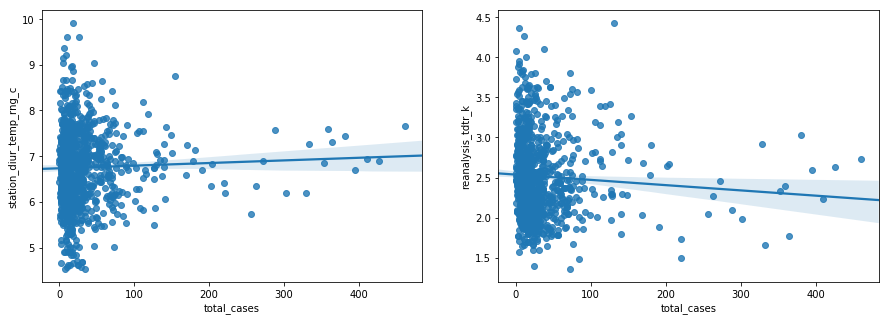

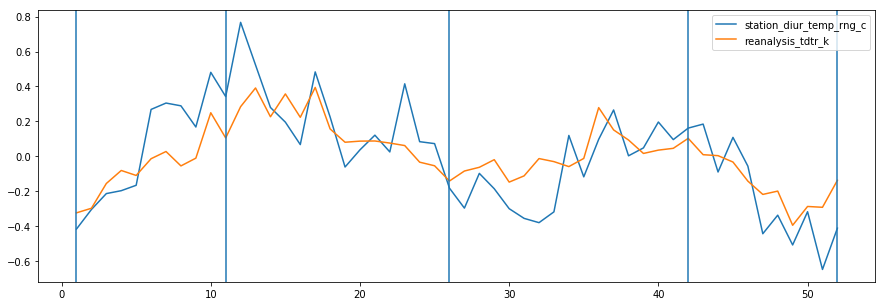

In [31]:
v = 'station_diur_temp_rng_c'
v2 = 'reanalysis_tdtr_k'

plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(sj.total_cases, sj[v])
plt.subplot(122)
sns.regplot(sj.total_cases, sj[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(sj.groupby('weekofyear')[v].mean() - 
                 sj[v].mean(),
            label=v)

plt.plot(sj.groupby('weekofyear')[v2].mean() - 
                 sj[v2].mean(),
            label=v2)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])
plt.legend()
plt.show()

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


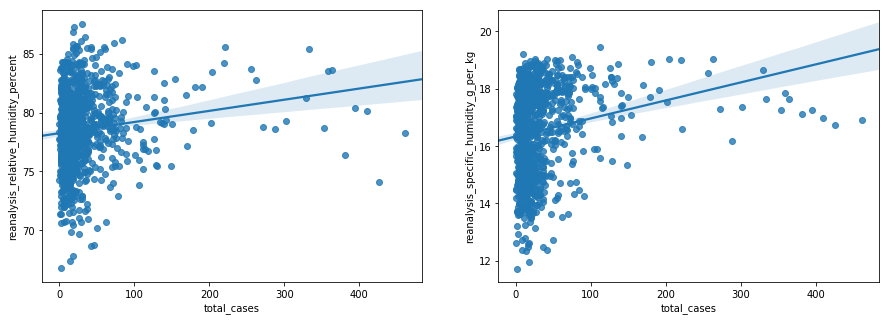

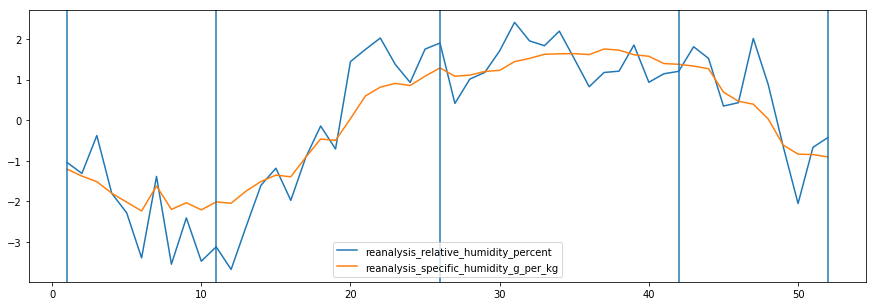

In [32]:
v = 'reanalysis_relative_humidity_percent'
v2 = 'reanalysis_specific_humidity_g_per_kg'

plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(sj.total_cases, sj[v])
plt.subplot(122)
sns.regplot(sj.total_cases, sj[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(sj.groupby('weekofyear')[v].mean() - 
                 sj[v].mean(),
            label=v)

plt.plot(sj.groupby('weekofyear')[v2].mean() - 
                 sj[v2].mean(),
            label=v2)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])
plt.legend()
plt.show()

#### Conclusion: Humidity and temperature range

I will not include the temperature ranges. The humidity measurements appear to be useful and one is a more volatile version of the other. for now I will include them both, but I may consider PCA to combine them at a later point.

In [33]:
v = 'reanalysis_relative_humidity_percent'
v2 = 'reanalysis_specific_humidity_g_per_kg'
feats.loc[:,v] = sj[v]
feats.loc[:,v2] = sj[v2]
feats.corr()['total_cases']

year                                    -0.212690
weekofyear                               0.287245
total_cases                              1.000000
station_max_temp_c                       0.188447
temps_mean                               0.197005
winter                                  -0.088709
spring                                  -0.274548
summer                                   0.164571
fall                                     0.204183
reanalysis_relative_humidity_percent     0.144404
reanalysis_specific_humidity_g_per_kg    0.206942
Name: total_cases, dtype: float64

### Rain

In [34]:
rain = ['total_cases',
       'precipitation_amt_mm', 
       'reanalysis_precip_amt_kg_per_m2',
       #'reanalysis_sat_precip_amt_mm', # identical to precipitation_amt_mm
       'station_precip_mm']
sj[rain].corr()

,total_cases,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,station_precip_mm
total_cases,1.000000,0.060296,0.106939,0.051883
precipitation_amt_mm,0.060296,1.000000,0.508274,0.566660
reanalysis_precip_amt_kg_per_m2,0.106939,0.508274,1.000000,0.477984
station_precip_mm,0.051883,0.566660,0.477984,1.000000


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


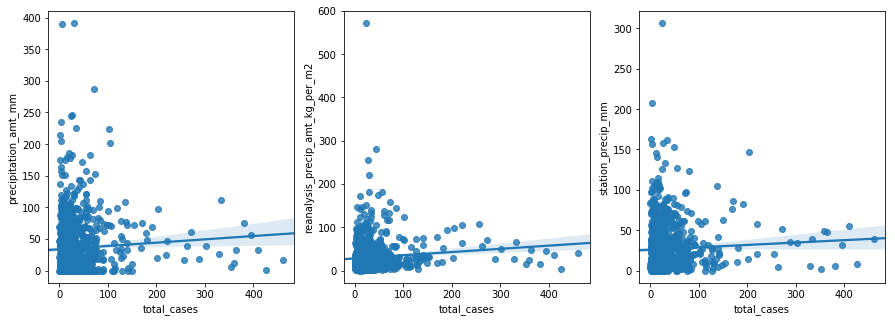

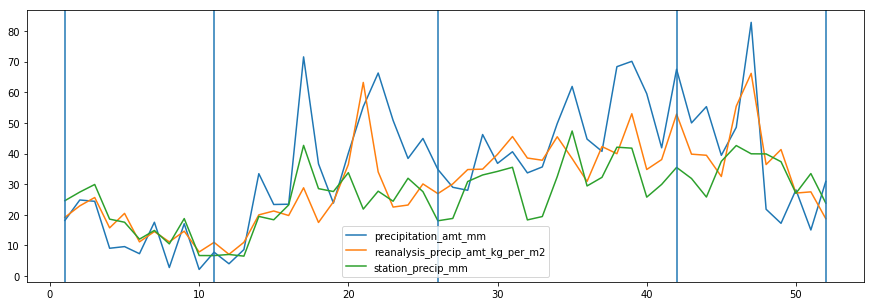

In [35]:
v = 'precipitation_amt_mm'
v2 = 'reanalysis_precip_amt_kg_per_m2'
v3 = 'station_precip_mm'

plt.figure(figsize=[15,5])
plt.subplot(131)
sns.regplot(sj.total_cases, sj[v])
plt.subplot(132)
sns.regplot(sj.total_cases, sj[v2])
plt.subplot(133)
sns.regplot(sj.total_cases, sj[v3])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(sj.groupby('weekofyear')[v].mean(), 
            label=v)
plt.plot(sj.groupby('weekofyear')[v2].mean(),
            label=v2)
plt.plot(sj.groupby('weekofyear')[v3].mean(), 
            label=v3)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])
plt.legend()
plt.show()

#### Conclusion: Rain

I will include only the strongest correlated variable, reanalysis_precip_amt_kg_per_m2

In [36]:
v = 'reanalysis_precip_amt_kg_per_m2'
feats.loc[:,v] = sj[v]
feats.corr()['total_cases']

year                                    -0.212690
weekofyear                               0.287245
total_cases                              1.000000
station_max_temp_c                       0.188447
temps_mean                               0.197005
winter                                  -0.088709
spring                                  -0.274548
summer                                   0.164571
fall                                     0.204183
reanalysis_relative_humidity_percent     0.144404
reanalysis_specific_humidity_g_per_kg    0.206942
reanalysis_precip_amt_kg_per_m2          0.106939
Name: total_cases, dtype: float64

### Vegetation

In [37]:
vegs = ['total_cases', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']
sj[vegs].corr()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
total_cases,1.000000,0.085918,0.047403,-0.043680,0.042670
ndvi_ne,0.085918,1.000000,0.632660,0.219353,0.181035
ndvi_nw,0.047403,0.632660,1.000000,0.197311,0.217740
ndvi_se,-0.043680,0.219353,0.197311,1.000000,0.814621
ndvi_sw,0.042670,0.181035,0.217740,0.814621,1.000000


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


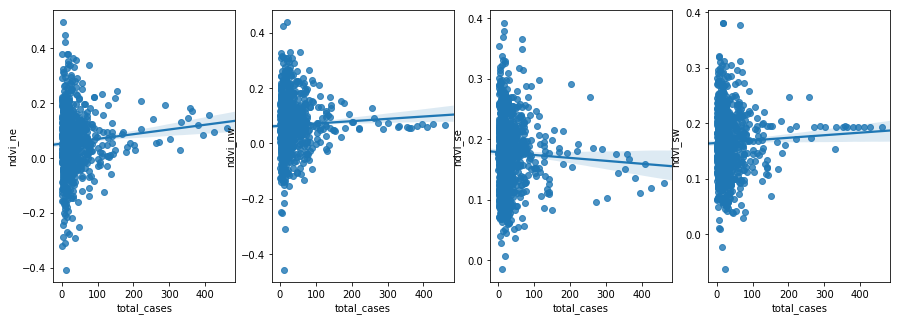

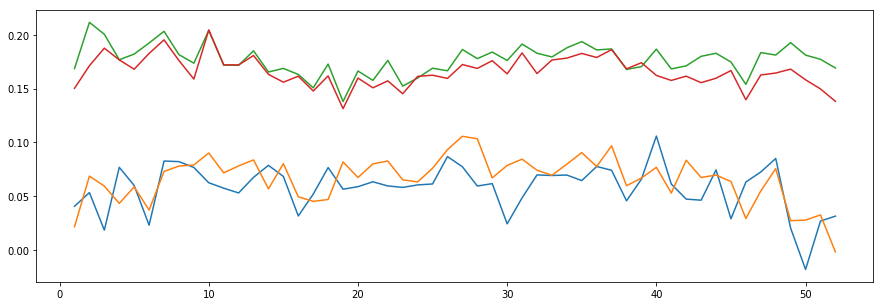

In [38]:
plt.figure(figsize=[15,5])
for i,col in enumerate(vegs[1:]):
    plt.subplot(1,4,i+1)
    sns.regplot(sj.total_cases, sj[col])
plt.show()

plt.figure(figsize=[15,5])
for v in vegs[1:]:
    plt.plot(sj.groupby('weekofyear')[v].mean(), 
            label=v)
plt.show()

#### Conclusion: Vegetation
Excluded

# Modelling with chosen features

In [39]:
def examine(y_pred, y_test):
    c = pd.DataFrame({
        'y' : y_test,
        'p' : y_pred
     })
    c = c.sort_index()
    plt.figure(figsize=[15,4])
    plt.plot(c.y, color='green')
    plt.plot(c.p, color='red')
    plt.show()

In [40]:
feats.head()

,city,year,weekofyear,total_cases,station_max_temp_c,temps_mean,winter,spring,summer,fall,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_precip_amt_kg_per_m2
0,sj,1990,18,4,29.4,0.324516,0,1,0,0,73.365714,14.012857,32.00
1,sj,1990,19,5,31.7,0.481929,0,1,0,0,77.368571,15.372857,17.94
2,sj,1990,20,4,32.2,0.551015,0,1,0,0,82.052857,16.848571,26.10
3,sj,1990,21,3,33.3,0.599826,0,1,0,0,80.337143,16.672857,13.90
4,sj,1990,22,6,35.0,0.692043,0,1,0,0,80.460000,17.210000,12.20


In [41]:
X = feats.drop(['total_cases', 'city', 'year', 'weekofyear', 'winter'], axis=1)
X2 = feats.drop(['total_cases', 'city', 'year', 'weekofyear'], axis=1) #for regularizing techniques
y = feats.total_cases

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(655, 8)
(281, 8)


#### Linear Regression

In [43]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-32.33681277 -32.04734764 -28.78655454]
28.04361002665853


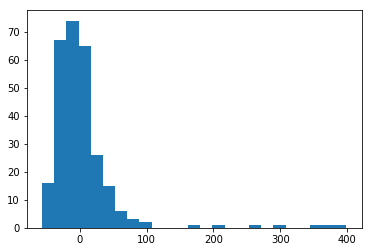

In [44]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

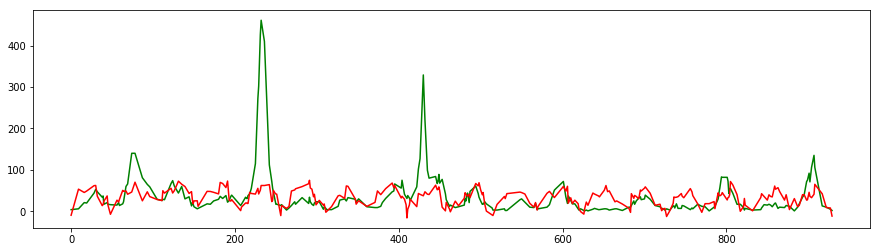

In [45]:
examine(y_pred, y_test)

### Random Forest Regressor

In [46]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

26.324661921708188
[-33.17156915 -36.18159574 -29.15045699]


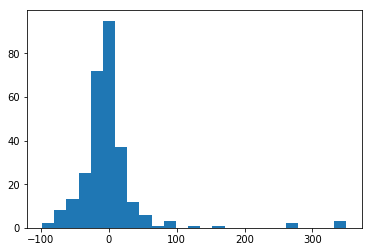

In [47]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

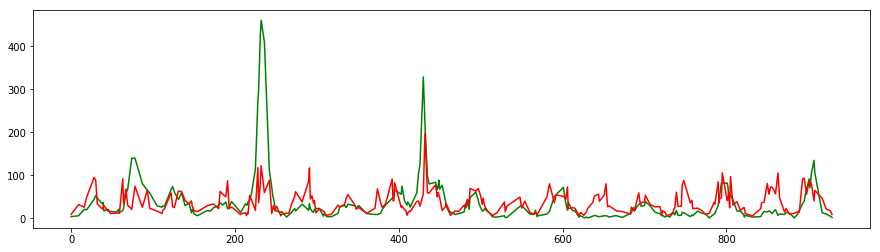

In [48]:
examine(y_pred, y_test)

### KNN Regressor

In [49]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

29.93613054733912
[-36.45819335 -27.87766401 -34.45860209]


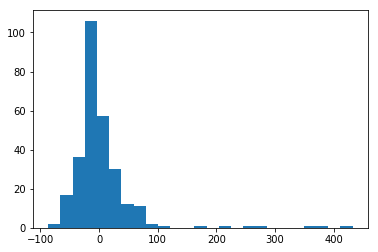

In [50]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

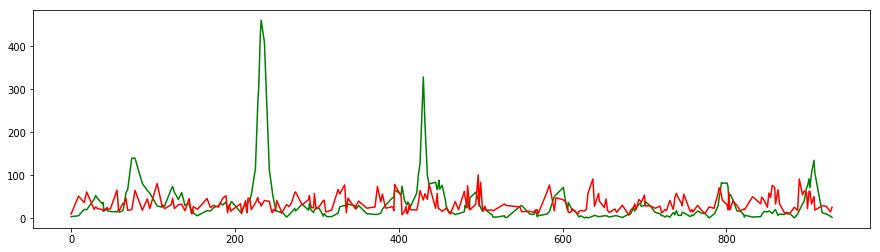

In [51]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [52]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=2,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

25.4133678494963
[-31.40244297 -20.86878586 -31.21607881]


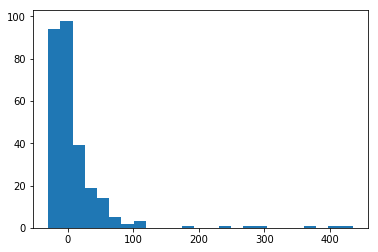

In [53]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

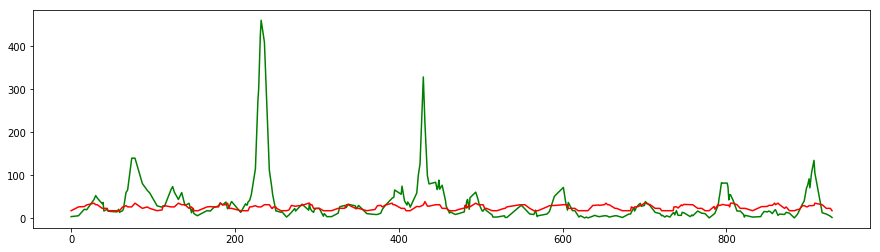

In [54]:
examine(y_pred, y_test)

###  Support Vector Regression

In [55]:
svr = SVR(gamma='auto')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

26.594711319273745
[-28.31151555 -19.72718231 -32.3541399 ]


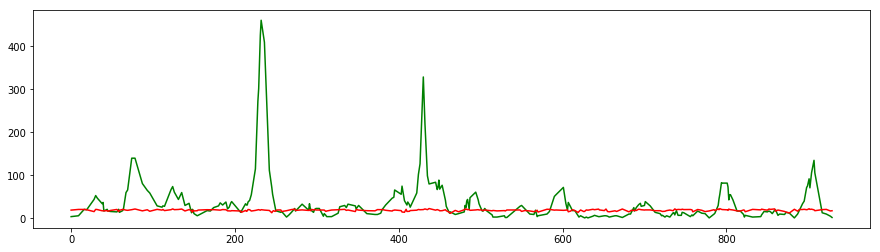

In [56]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [57]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [58]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ station_max_temp_c + temps_mean + spring + summer + fall + reanalysis_relative_humidity_percent + reanalysis_specific_humidity_g_per_kg + reanalysis_precip_amt_kg_per_m2'

In [59]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [60]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

26.71174377224199

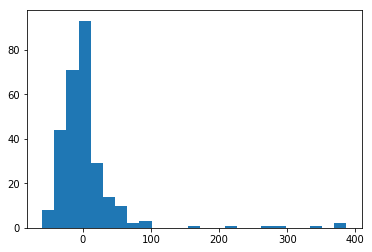

In [61]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

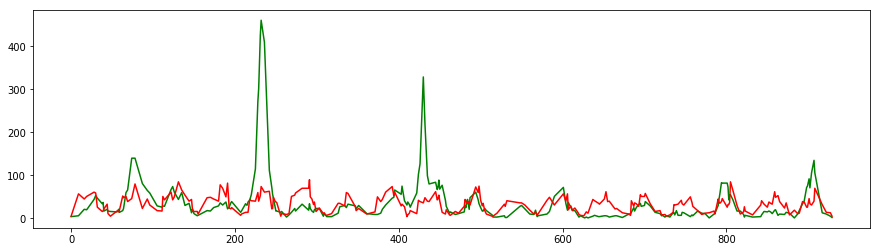

In [62]:
examine(predictions, y_test)

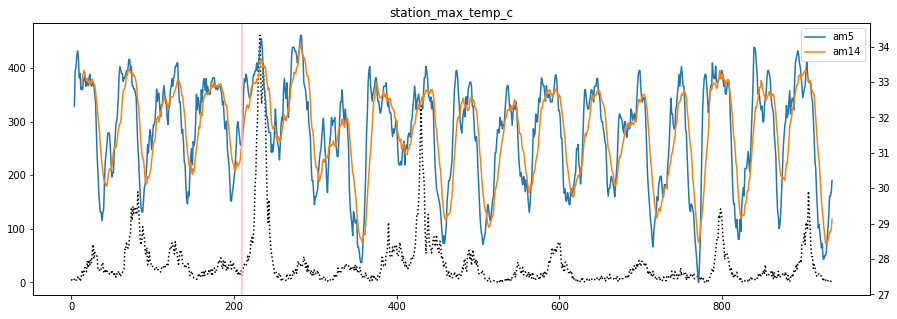

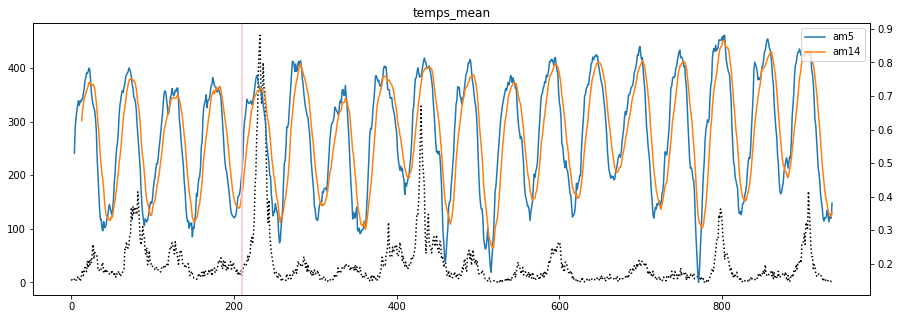

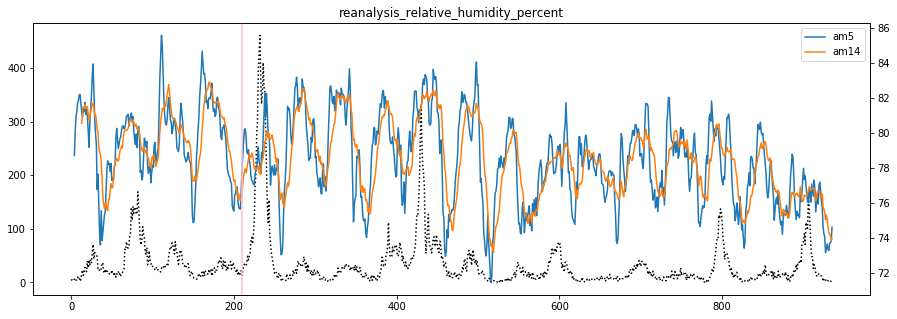

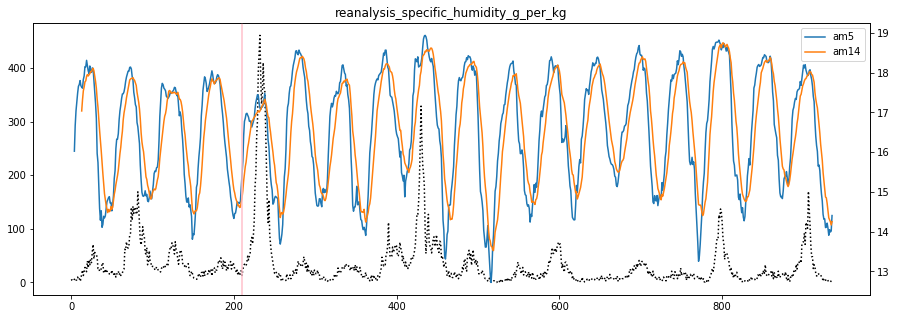

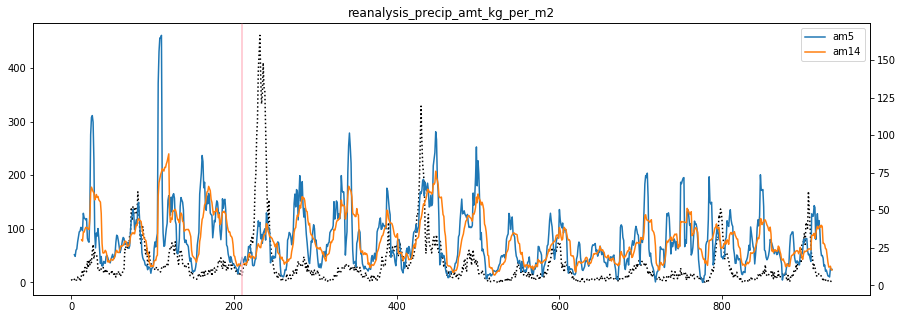

In [83]:
#Looking for leading indicators in moving averages?
toplot = ['station_max_temp_c',
       'temps_mean',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2']

for var in toplot:
    df = pd.DataFrame({
        'total_cases': feats['total_cases'],
        var : feats[var],
    })
    fig, ax1 = plt.subplots(figsize=(15,5))
    ax1.plot(df['total_cases'], ':',label='total_cases', color='black')
    ax2 = ax1.twinx()
    for w in [5,14]:
        ax2.plot(df.rolling(window=w)[var].mean(), label='am'+str(w))
    plt.axvline(x=210, color='pink')
    plt.legend(loc=1)
    plt.title(var)
    plt.show()    

In [86]:
toplot2 = ['station_max_temp_c', 'station_avg_temp_c',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2',
       'precipitation_amt_mm', 'station_precip_mm']

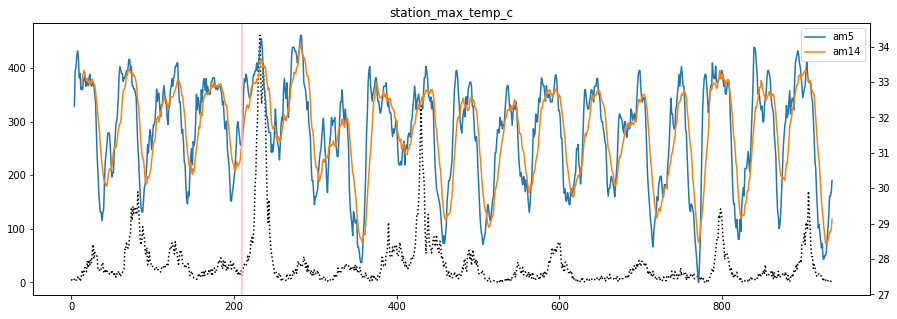

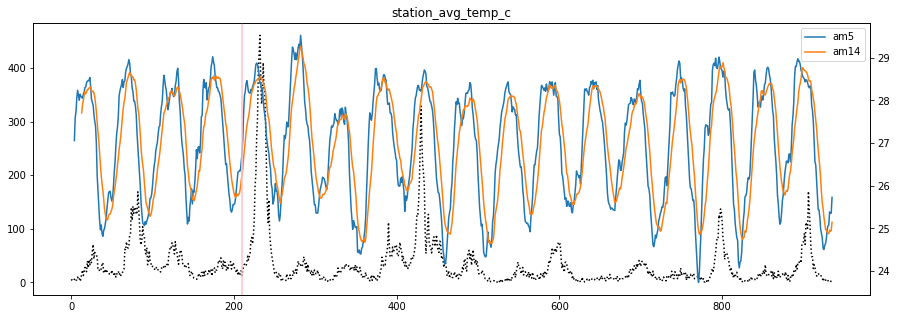

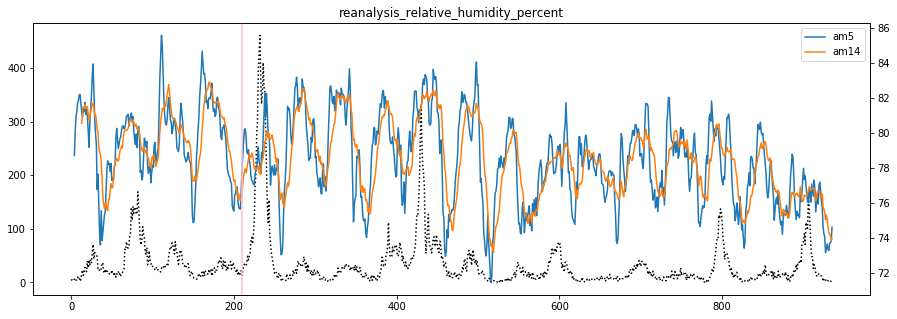

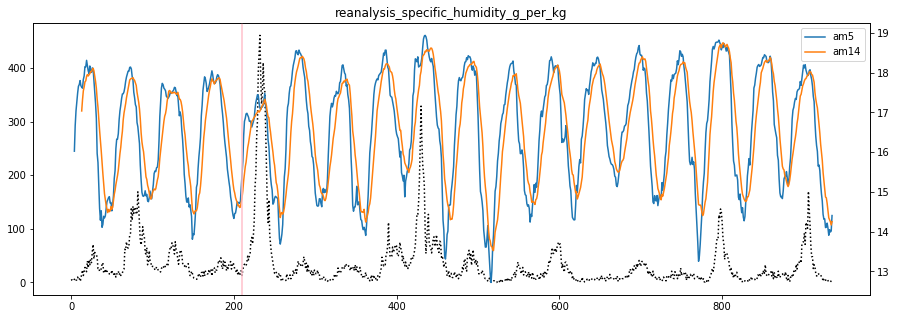

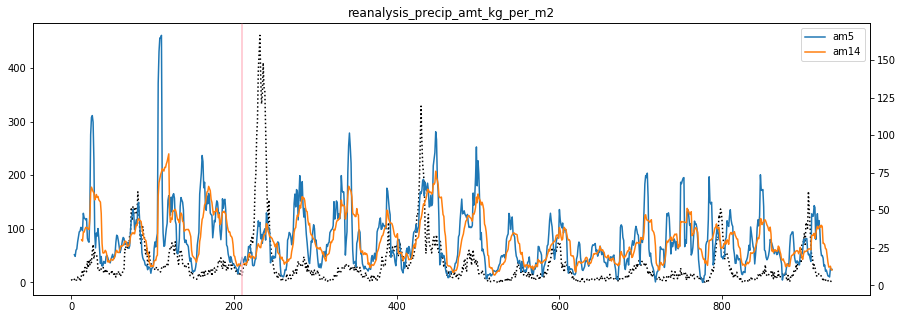

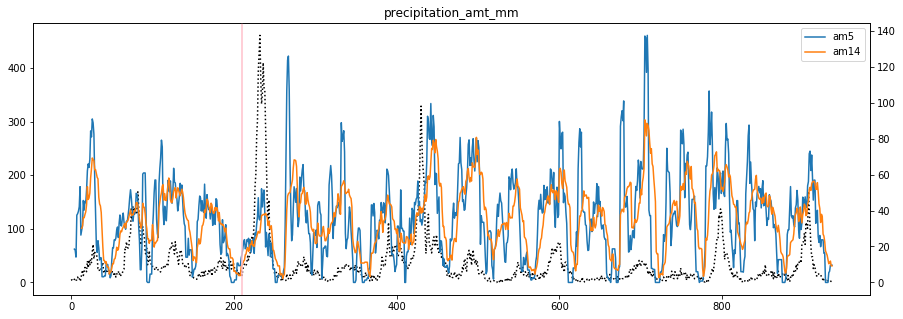

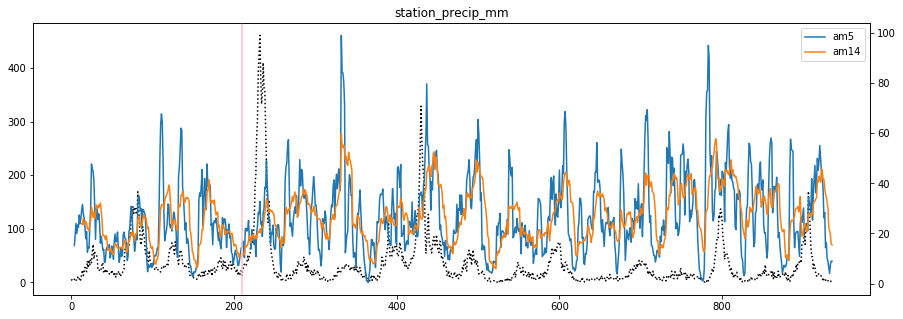

In [87]:
rawfeats2 = sj.interpolate(method='linear')
for var in toplot2:
    df = pd.DataFrame({
        'total_cases': rawfeats2['total_cases'],
        var : rawfeats2[var],
    })
    fig, ax1 = plt.subplots(figsize=(15,5))
    ax1.plot(df['total_cases'], ':',label='total_cases', color='black')
    ax2 = ax1.twinx()
    for w in [5,14]:
        ax2.plot(df.rolling(window=w)[var].mean(), label='am'+str(w))
    plt.axvline(x=210, color='pink')
    plt.legend(loc=0)
    plt.title(var)
    plt.show()    

In [102]:
#Dumb based on whatever
feats.columns

Index(['city', 'year', 'weekofyear', 'total_cases', 'station_max_temp_c',
       'temps_mean', 'winter', 'spring', 'summer', 'fall',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2'],
      dtype='object')

In [109]:
shiftedfeats = feats[['city', 'year', 'weekofyear', 'total_cases',
                      'winter', 'spring', 'summer', 'fall']].copy()
for i in ['station_max_temp_c', 'temps_mean',
          'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2']:
    shiftedfeats[i] = feats[i].shift(-2)

shiftedfeats = shiftedfeats.fillna(method='ffill')
shiftedfeats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 13 columns):
city                                     936 non-null object
year                                     936 non-null int64
weekofyear                               936 non-null int64
total_cases                              936 non-null int64
winter                                   936 non-null int32
spring                                   936 non-null int32
summer                                   936 non-null int32
fall                                     936 non-null int32
station_max_temp_c                       936 non-null float64
temps_mean                               936 non-null float64
reanalysis_relative_humidity_percent     936 non-null float64
reanalysis_specific_humidity_g_per_kg    936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
dtypes: float64(5), int32(4), int64(3), object(1)
memory usage: 84.1+ KB


In [110]:
X = shiftedfeats.drop(['total_cases', 'city', 'year', 'weekofyear', 'winter'], axis=1)
X2 = shiftedfeats.drop(['total_cases', 'city', 'year', 'weekofyear'], axis=1) #for regularizing techniques
y = shiftedfeats.total_cases

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(655, 8)
(281, 8)


#### Linear Regression

In [112]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-21.85213509 -19.38761794 -21.55743887]
24.636481841938526


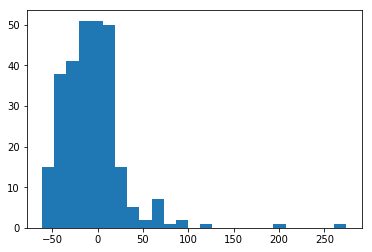

In [113]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

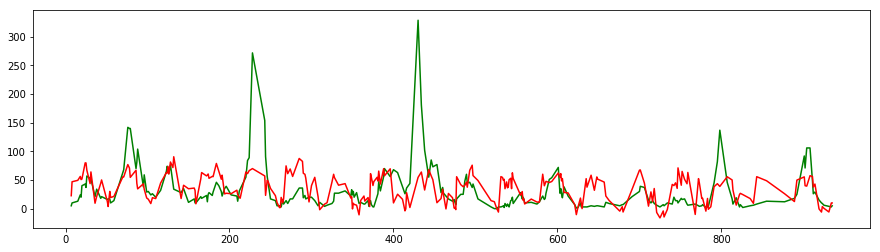

In [114]:
examine(y_pred, y_test)

### Random Forest Regressor

In [115]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

24.784555160142347
[-21.58518617 -21.78635638 -25.1961828 ]


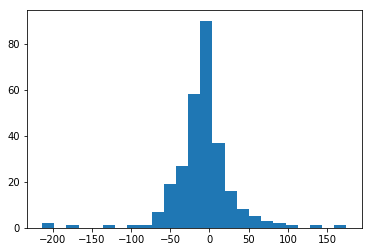

In [116]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

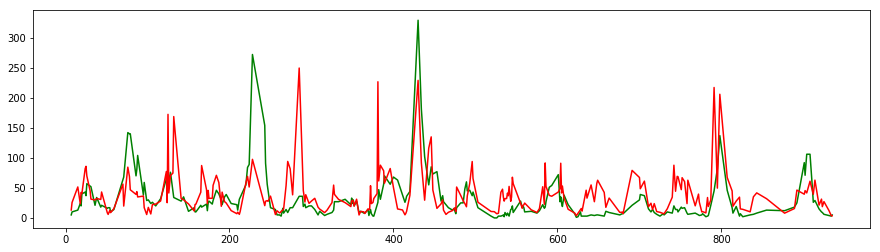

In [117]:
examine(y_pred, y_test)

### KNN Regressor

In [118]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

26.130529456746423
[-23.38739469 -23.53927997 -23.97311948]


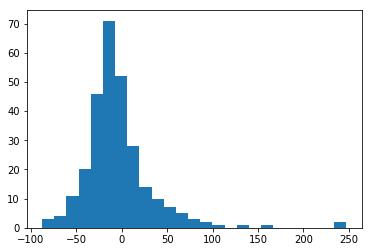

In [119]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

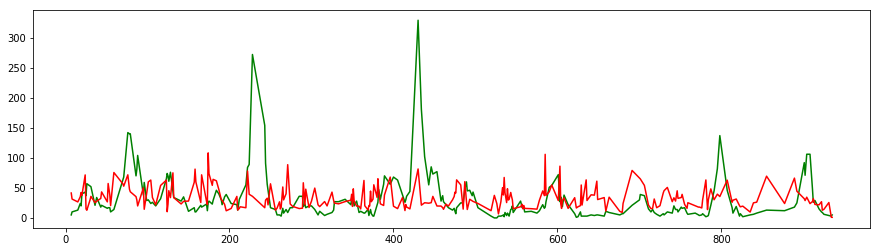

In [120]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [121]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=2,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

20.465790819501805
[-20.0214311  -18.27078829 -22.05241246]


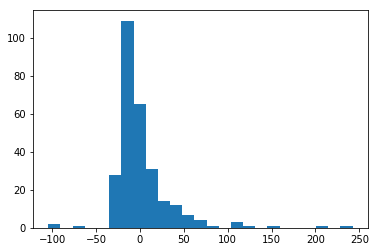

In [122]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

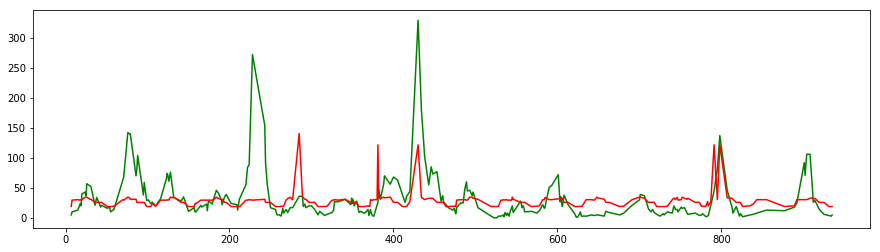

In [123]:
examine(y_pred, y_test)

###  Support Vector Regression

In [124]:
svr = SVR(gamma='auto')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

20.454023661074988
[-21.4533646  -19.13886815 -21.21693052]


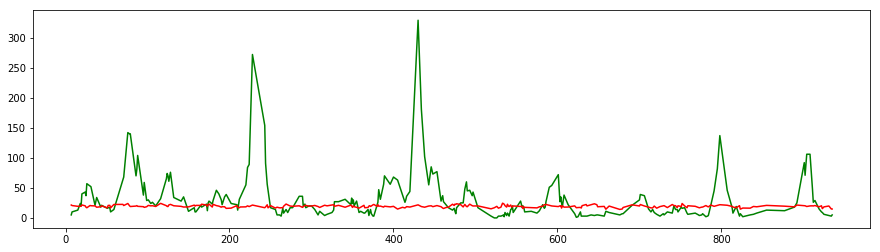

In [125]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [126]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [127]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ spring + summer + fall + station_max_temp_c + temps_mean + reanalysis_relative_humidity_percent + reanalysis_specific_humidity_g_per_kg + reanalysis_precip_amt_kg_per_m2'

In [128]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [129]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

23.295373665480426

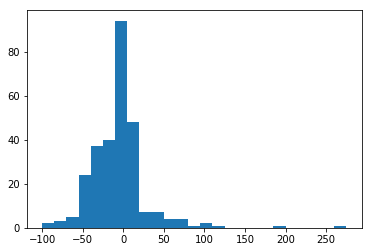

In [130]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

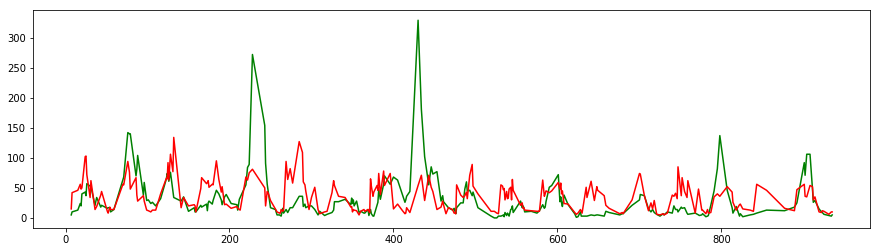

In [131]:
examine(predictions, y_test)